In [1]:
%matplotlib widget
# %matplotlib notebook doesn't work on vscode

import matplotlib.pyplot as plt
import numpy as np 
from numba import jit
from numpy import sin, pi
from pathlib import Path

%reload_ext autoreload
%aimport Funcs
%aimport visualization
%aimport species_transport

from parameters import *

In [2]:
# load the velocity field:
N, M = 50,50
datap = Path('data/vel_field') / 'N{}M{}.npy'.format(N,M)
u,v = np.load(datap)

In [3]:
%autoreload 1
from species_transport import set_CH4_BC, set_O2_BC, set_N2_BC, set_CO2_BC, set_H2O_BC, set_Temp_BC

Nt = 10000

CH4, O2, N2, H2O, CO2, T = np.zeros((6,N,M))

O2[:] = .233
N2[:] = .767
T[:] = 300
BCs = [set_CH4_BC, set_O2_BC, set_N2_BC, set_H2O_BC, set_CO2_BC]

Y = np.array([CH4, O2, N2, CO2, H2O])
Y_t = np.zeros((*Y.shape, Nt))
T_t = np.zeros((*T.shape, Nt))

In [4]:
from Funcs import advance_adv_diff_RK4

dt=1e-6

def evolve_species(Y, T, BCs, kspec='all'):
    
    nspec = Y.shape[0]
    
    if kspec=='all':
        kspec = np.arange(nspec)
    
    for n in range(Nt):
        for k in kspec:
            # apply BCs
            Y[k] = BCs[k](Y[k])
            
            if k in kspec[:-1]:
                Y[k] = advance_adv_diff_RK4(Y[k], dt, u, v, dx, dy, nu)
                
            else:
                # normalization condition:
                Y[k] = 1 + Y[k] - np.sum(Y, axis=0)
            Y[k] = BCs[k](Y[k])
            
        # (almost) same procedure for temperature:
        #T = advance_adv_diff(T, dt, u, v, dx, dy, nu)
        T = set_Temp_BC(T)
        
        Y_t[:,:,:,n] = Y
        T_t[:,:,n]   = T
        
    return Y, T

In [5]:
Y, T = evolve_species(Y, T, BCs, kspec='all')

In [6]:

data_sp = Path('data/species') / 'N{}M{}.npy'.format(N,M)
species_data = np.zeros((Y.shape[0] + 1, *Y.shape[1:]))
species_data[:-1,:, :] = Y
species_data[-1, :, :] = T
np.save(data_sp, species_data)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
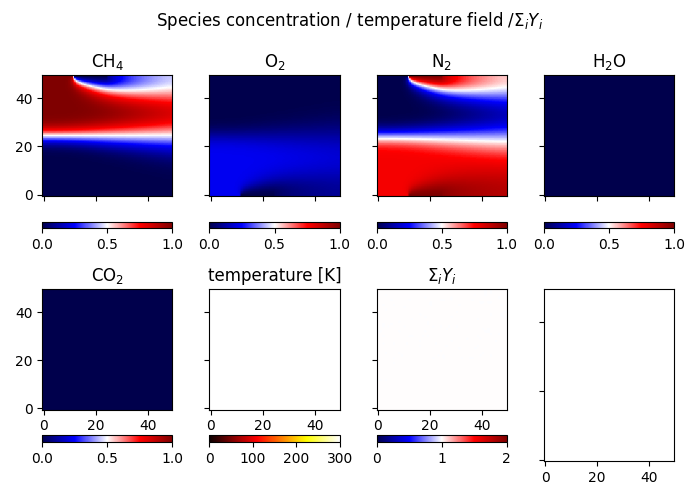

In [7]:
from visualization import plot_species_overview
%autoreload 1
fig, axs =plt.subplots(2, 4, figsize=(7,5.),sharex=True, sharey=True)
plot_species_overview(Y,T, axs=axs)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
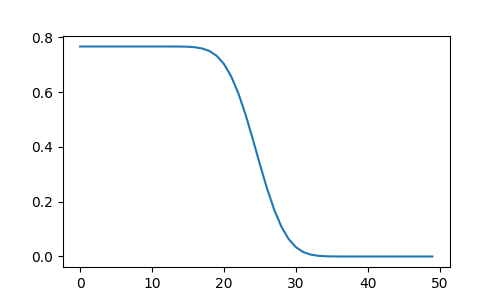

In [8]:
left_wall_N2 = Y_t[2,0,:,-1]
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(left_wall_N2)